## **0. 루브릭**

| 평가문항 | 상세기준 |
|----------|-----------|
| 1. multiface detection을 위한 widerface 데이터셋의 전처리가 적절히 진행되었다. | tfrecord 생성, augmentation, prior box 생성 등의 과정이 정상적으로 진행되었다. |
| 2. SSD 모델이 안정적으로 학습되어 multiface detection이 가능해졌다. | inference를 통해 정확한 위치의 face bounding box를 detect한 결과이미지가 제출되었다. |
| 3. 이미지 속 다수의 얼굴에 스티커가 적용되었다. | 이미지 속 다수의 얼굴의 적절한 위치에 스티커가 적용된 결과이미지가 제출되었다. |

## **1. 실험하기**

### **1. 데이터셋 전처리**

### **(1) 분석**

**WIDER FACE Bounding Box**

오늘 다루게 될 WIDER FACE 데이터셋은 Face detection을 위한 데이터셋이고, 

입력데이터는 이미지 파일로, Ground Truth는 Bounding box 정보로 되어 있습니다.

본격적으로 코드를 다루기 전에 필요한 라이브러리와 전역 변수를 준비합니다.

In [1]:
# 라이브러리 불러오기
import os
import cv2
import time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# 전역변수 설정하기
PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

먼저 bounding box 파일을 분석해 봅시다.

In [3]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

In [4]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

위 함수는 이미지별 bounding box 정보를 `wider_face_train_bbx_gt.txt`에서 파싱해서 리스트로 추출하는 것입니다.

이제 추출된 정보를 실제 이미지 정보와 결합합니다. **bounding box 정보**는 `[x, y, w, h]` 형태로 저장되어 있는데, `[x_min, y_min, x_max, y_max]` 형태의 꼭짓점 좌표 정보로 변환할 거예요.

In [5]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

In [6]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

잘 결합된 데이터의 형태를 확인해 봅시다.

In [7]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')

In [8]:
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

이미지별로 boxes 리스트에 담긴 bounding box 정보가 확인이 됩니다.

이제 이 정보를 활용하여 텐서플로우 데이터셋을 생성해 봅시다.

### **(2) TFRecord 생성**

**TFRecord 만들기**

대용량 데이터셋의 처리속도 향상을 위해서, 전처리 작업을 통해 TFRecord 데이터셋으로 변환할 필요가 있습니다.

**TFRecord**란 TensorFlow만의 학습 데이터 저장 포맷으로, 이진(binary) 레코드의 시퀀스를 저장합니다. TFRecord 형태의 학습 데이터를 사용하여 모델 학습을 하면 **학습 속도가 개선된다는 장점**이 있습니다.

TFRecord는 여러 개의 `tf.train.Example`로 이루어져 있고, 한 개의 `tf.train.Example`은 여러 개의 `tf.train.Feature`로 이루어져 있습니다.

In [9]:
# 데이터의 단위를 이루는 tf.train.Example 인스턴스를 생성하는 메소드 만들기
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

데이터셋의 이미지 파일, 그리고 bounding box 정보를 모아 위의 `make_example` 메소드를 통해 만든 example을 serialize하여 TFRecord 파일로 생성하게 됩니다.

TFRecord에 대한 자세한 사항은 아래를 참고하세요.
* [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord)

**Q. tf.Example은 무엇을 사용하여 데이터를 저장하고 있나요?**

tf.Example은 **프로토콜 버퍼(Protocol Buffer)를 사용**하여 데이터를 저장합니다. 프로토콜 버퍼는 Google에서 개발한 언어 중립적이고 플랫폼 중립적인 확장 가능한 메커니즘으로, 구조화된 데이터를 직렬화하는 데 사용됩니다. tf.Example 메시지는 특히 TensorFlow에서 학습 데이터를 효율적으로 저장하고 사용할 수 있도록 설계되었습니다.

In [10]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:13<00:00, 235.89it/s]


### **2. 모델 구현**

### **(1) Default boxes**

**SSD의 Default box**

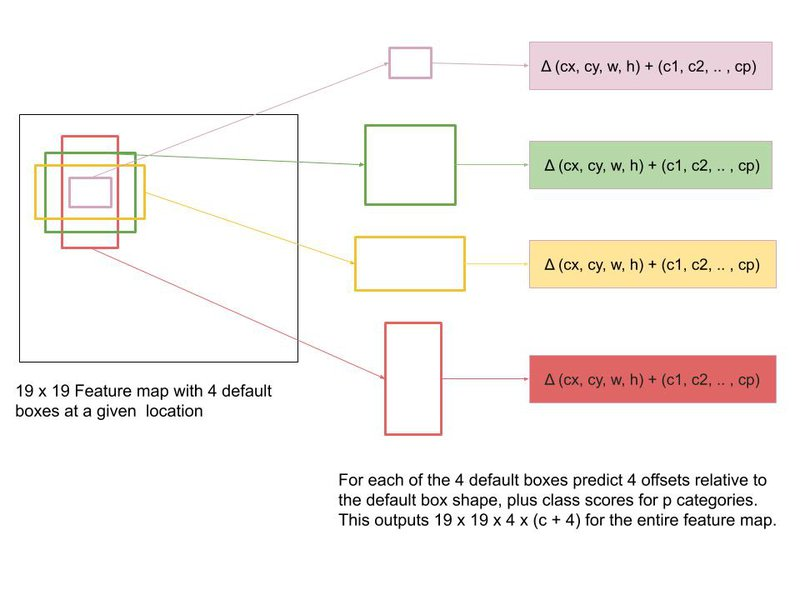

SSD 모델의 가장 중요한 특징 중 하나는 **Default box**를 필요로 한다는 점입니다.

**Default box**란, object가 존재할 만한 다양한 크기의 box의 좌표 및 클래스 정보를 일정 개수만큼 미리 고정해 둔 것입니다.

ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택하는 방식이 RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르면서도 그와 유사한 정도의 정확도를 얻을 수 있습니다.

**Q. SSD에서 default box를 선택하는 과정에 대해 설명해봅시다.**

SSD는 여러 층의 feature map에서 bbox를 만들어내기 때문에 층의 수 만큼 box의 수도 많아지고, 층마다 box의 크기도 다양하므로 여러 박스 중에서 ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택하게 됩니다.

이번 프로젝트에서 사용할 default box 정보를 전역 변수로 만들어 둡니다.

In [11]:
# default box 정보를 전역 변수로 만들어두기
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

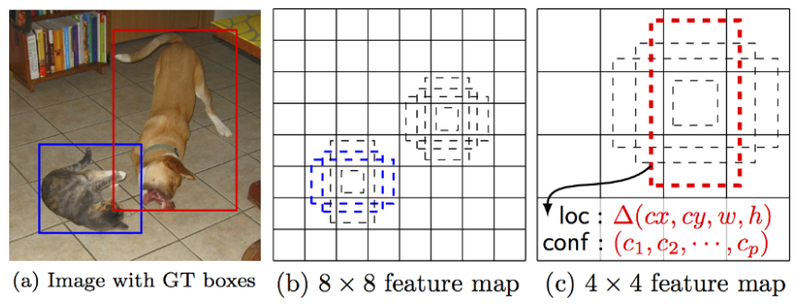

default box를 생성하기 위해서는 먼저 기준이 되는 feature map을 먼저 생성합니다.

우리의 프로젝트에서는 아래와 같이 4가지 유형의 feature map을 생성하게 됩니다.

In [12]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

In [13]:
feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]

feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

이제 feature map별로 순회를 하면서 default box 를 생성해 보겠습니다.

In [14]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

생성된 `boxes`에는 default box 정보가 구분없이 나열되어 있으므로 4개씩 재배열 시켜줍니다.

In [15]:
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


모두 4700개의 **default box**가 만들어 졌네요. 

`feature_maps`와 `min_sizes`로부터 `40x32x3 + 20x16x2 + 10x8x2 + 5x4x3` 개가 생성되었다는 걸 확인할 수 있습니다.

feature map을 만들고 그에 연결된 default box를 생성하는 코드를 사용하기 편리하도록 함수로 정의합시다.

In [16]:
# default box를 생성하는 코드를 함수로 정의하기
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

### **(2) SSD**

**SSD model 빌드하기**

그럼 본격적으로 SSD 모델을 생성해 보겠습니다.

**Convolution 블록**, **Depthwise Convolution 블록**, 그리고 skip connection으로 쓰일 **Branch 블록**을 준비합니다.

In [17]:
# Convolution 블록 정의하기
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

In [18]:
# Depthwise Convolution 블록 정의하기
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

In [19]:
# Branch 블록 정의하기
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 **헤드(head)** 라고 불리는 Convolution 레이어를 붙일 예정입니다.

**하나의 헤드에 Convolution 레이어 두 개**가 필요합니다. 

하나는 **confidence를 예측**하기 위해 사용하고 다른 하나는 **location을 예측**하기 위해 사용합니다.

Branch마다 헤드가 연결되어 있기 때문에 모델의 중간 레이어에서도 예측을 위한 정보를 가져올 수 있게 되었습니다.

In [20]:
# head 블록 생성한느 함수 정의하기
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

In [21]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

레이어들이 준비되었습니다. 이제 **본격적으로 SSD model을 준비**해 보겠습니다.

In [22]:
# SSD 모델 준비하기
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

준비한 모델을 생성해 봅시다.

In [23]:
# 모델 가져오기
model = SsdModel()

In [24]:
# 모델 요약하기
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

101층의 SSD 모델이 완성되었습니다.

### **3. 모델 학습**

### **(1) Augmentation, jaccard 적용**

**Augmentation**

Object detection에서 사용하는 다양한 augmentation 기법을 적용해 주면 성능이 조금 더 향상될 수도 있습니다.

먼저, 이미지를 `_crop`했을 때 box도 함께 잘릴 수가 있어요. 함께 신경써서 잘라줍니다.

In [25]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

`_resize`나 `_flip`도 box에 영향을 끼칩니다.

In [26]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [27]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

`_pad_to_square`는 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가해주는 작업입니다.

이미지 왼쪽이나 위쪽으로는 변화가 없기 때문에 box 정보는 변하지 않습니다.

In [28]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

이미지 색상 값만 바꿔주는 `_distort`에서도 box 정보를 바꿀 필요는 없을 것 같습니다.

In [29]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

**Default box 적용**

아래 메소드들은 default box와 bounding box 사이의 IoU, 다른 말로 **자카드 유사도(자카드 지수, jaccard index)를 측정**하기 위한 것입니다.

**자카드 유사도**는 두 집합을 통해 **유사도를 측정**하는 방식 중 하나로, 두 집합의 교집합을 두 집합의 합집합으로 나눕니다. 

따라서 자카드 유사도는 0과 1 사이의 값을 가지며, 두 집합의 합집합과 교집합이 서로 비슷하면 1에 근접하다는 뜻입니다.

* 자카드 유사도

$[ 
J(X, Y) = \frac{|X \cap Y|}{|X \cup Y|} = \frac{|X \cap Y|}{|X| + |Y| - |X \cap Y|}, \quad 0 \leq J(X, Y) \leq 1 
$]

In [30]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

In [31]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

아래 `encode_tf`는 이를 이용해서 TFRecord 데이터셋의 라벨을 가공하는 메소드입니다.

* jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched box를 구한다.
* `_encode_bbox` 메소드를 통해 bbox의 scale을 동일하게 보정한다.
* 전체 default box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트한다.

In [32]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

In [33]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

**load_dataset**

이전 스텝에서 생성한 tfrecord 데이터셋에 적용하여 SSD 학습을 위한 데이터셋을 생성하는 최종 메소드인 `load_dataset` 을 구현합니다.

* `_transform_data` : augmemtation과 label을 encoding 하여 기존의 dataset을 변환하는 메소드
* `_parse_tfrecord` : TFRecord 에 `_transform_data`를 적용하는 함수 클로저 생성
* `load_tfrecord_dataset` : `tf.data.TFRecordDataset.map()`에 `_parse_tfrecord`을 적용하는 실제 데이터셋 변환 메인 메소드
* `load_dataset` : `load_tfrecord_dataset`을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [34]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

In [35]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

In [36]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [37]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

상당히 긴 데이터 준비 과정이 끝났습니다.

### **(2) train**

**Learning rate scheduler**

초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가할 수 있도록 

학습 스텝에 따라 다른 Learning Rate이 적용될 수 있도록 하겠습니다.

In [38]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

In [39]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

**Hard negative mining**

학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 

positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다.

실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 

그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많기 십상이므로 

negative 비율을 positive의 3배가 되도록 설정해 주었습니다.

In [40]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [41]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

**Training**

이제 본격적으로 모델 학습을 진행하겠습니다.

Default box를 만들고 데이터셋을 준비합니다.

In [42]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

모델을 만들고 살펴봅시다.

In [43]:
model = SsdModel()

In [44]:
model.summary()

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_15 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_15 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_15[0][0]                
__________________________________________________________________________________________________
conv_bn_15 (BatchNormalization) (None, 128, 160, 16) 64          conv_15[0][0]                    
__________________________________________________________________________________________

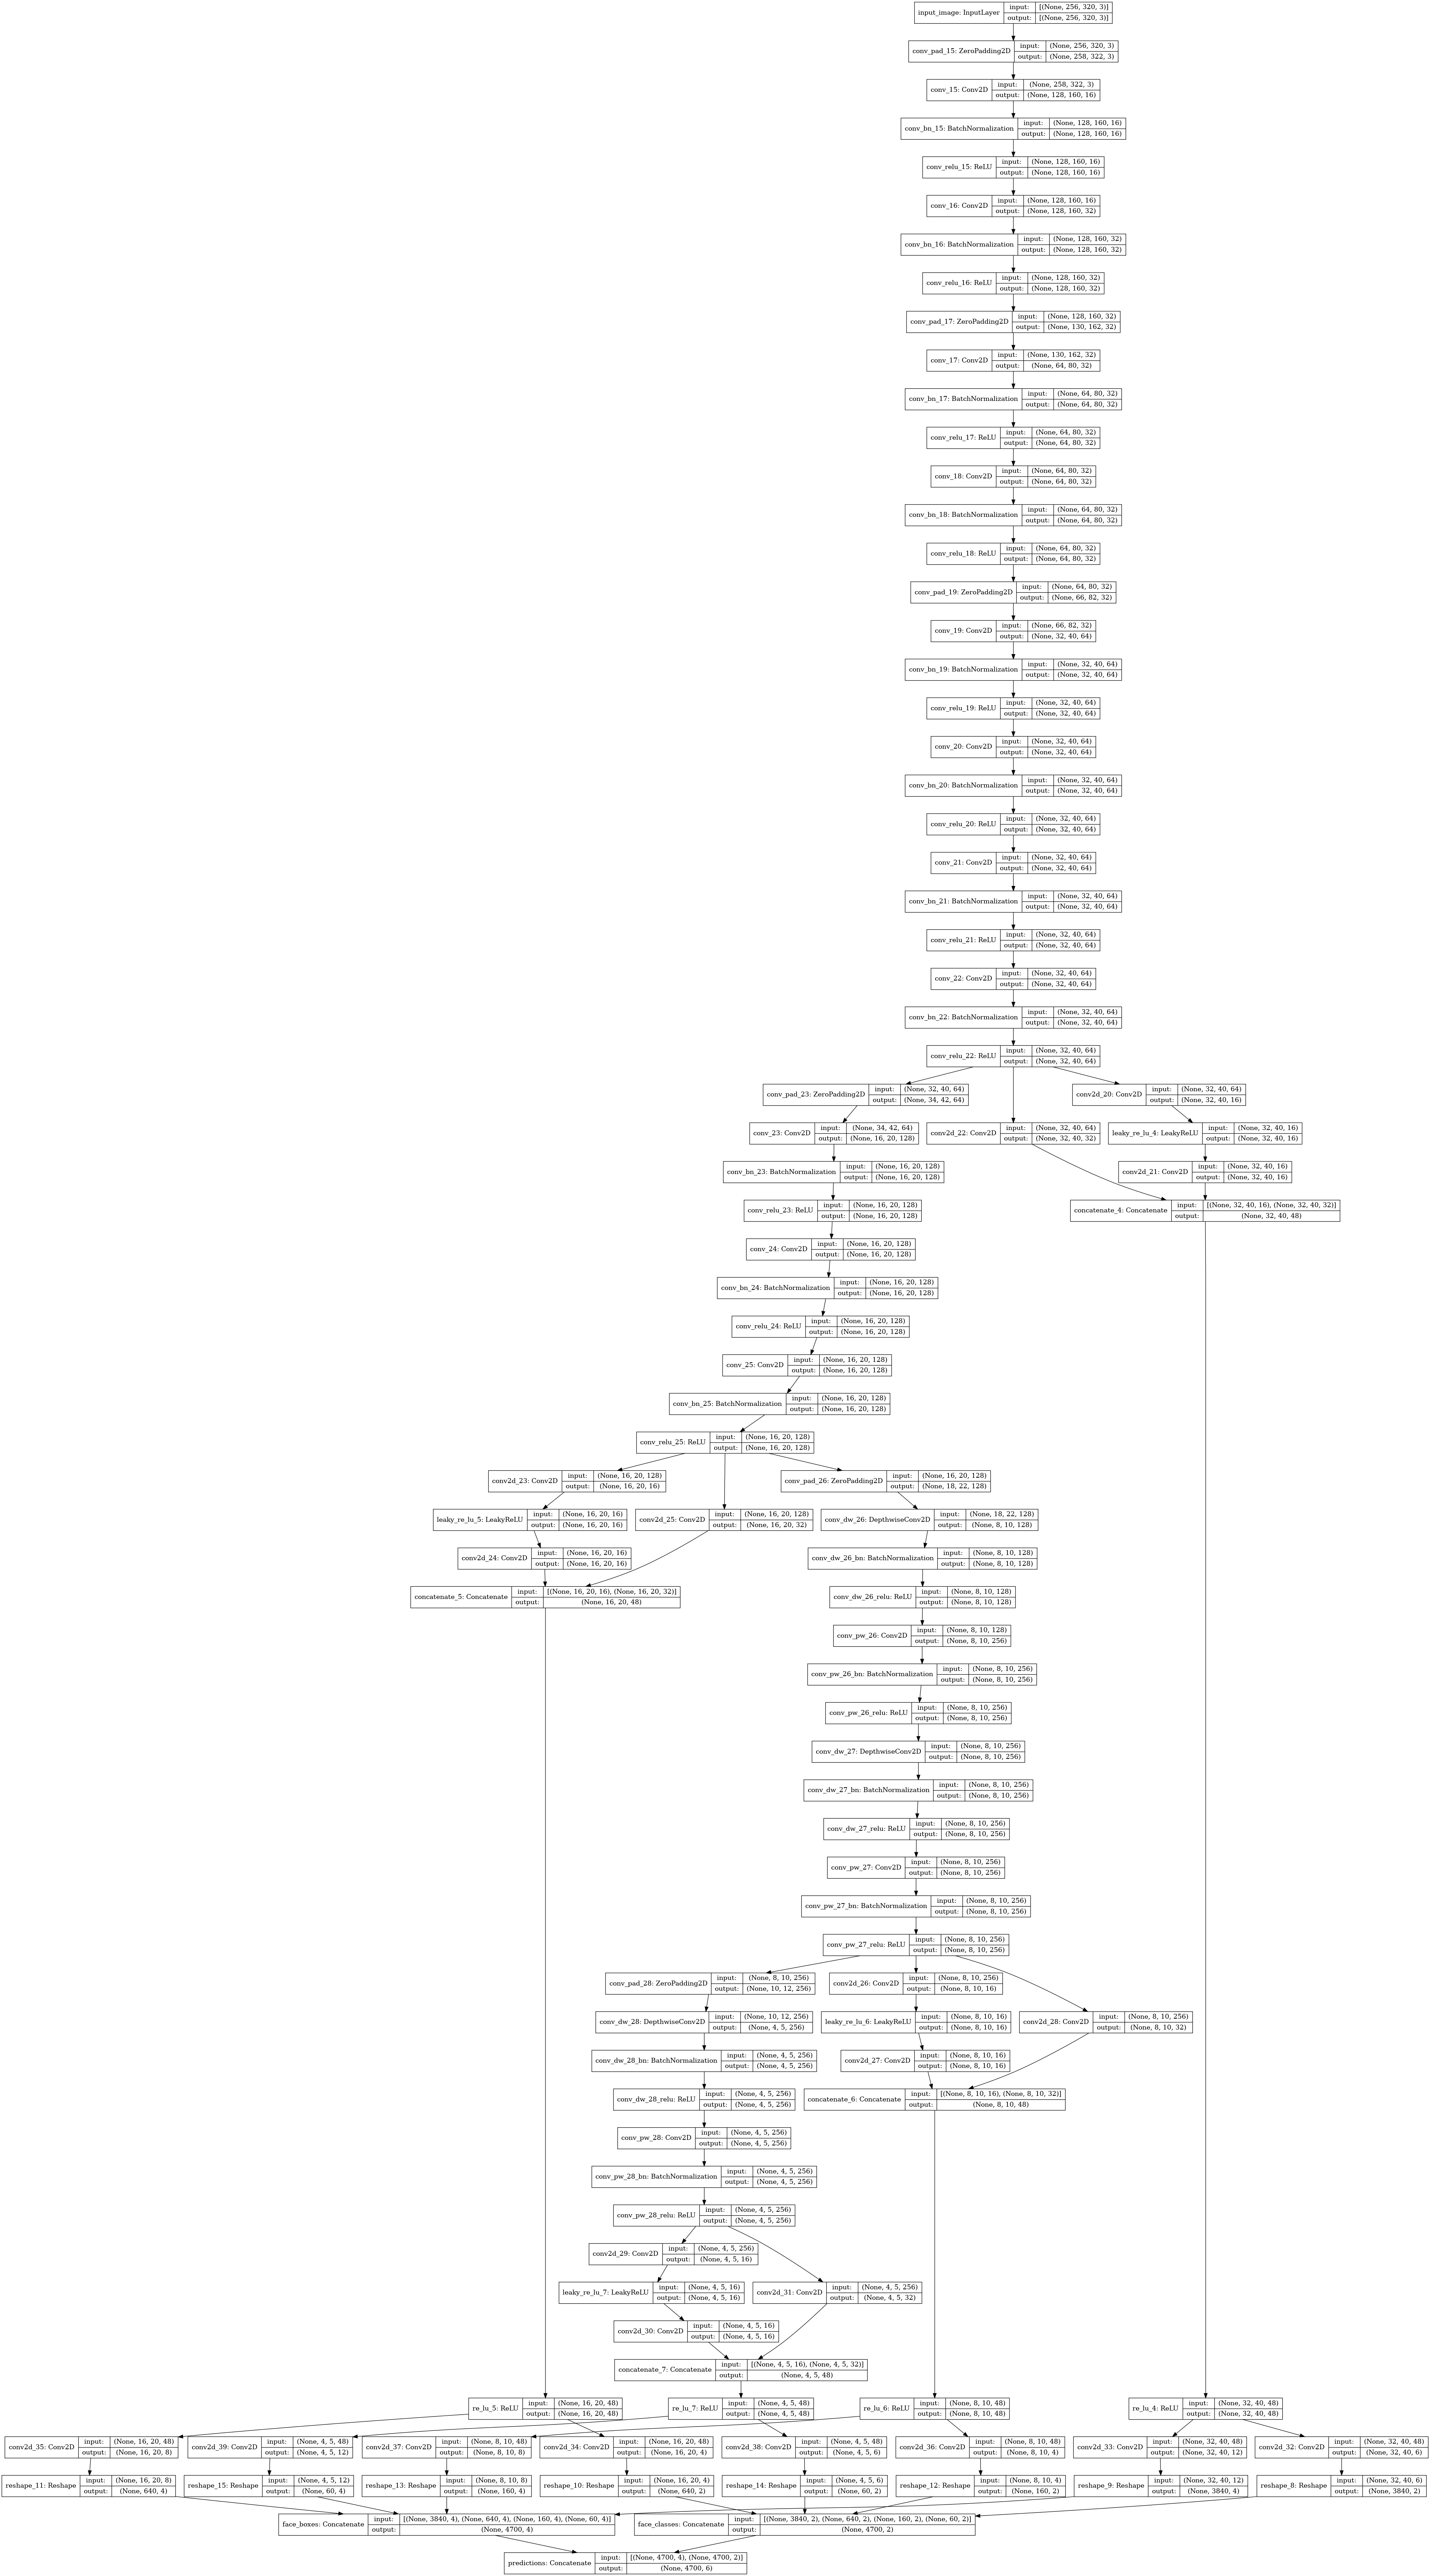

In [45]:
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

나머지 학습에 필요한 요소들도 생성해 줍니다.

In [46]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

이제 학습이 진행될 함수를 작성할 차례입니다.

한 스텝이 학습되는 함수를 아래처럼 작성합니다.

In [47]:
# 한 스텝이 학습되는 함수 작성하기
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

아래에서 본격적으로 train을 시작합니다. 100 epochs로 학습해봅니다.

In [48]:
# 학습 횟수 설정하기
EPOCHS = 100

In [49]:
for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

Epoch: 100/100 | Batch 402/402 | Batch time 0.082 || Loss: 3.304231 | loc loss:2.256550 | class loss:1.047681  

### **4. inference**

**Q. NMS는 어떤 문제를 해결하기 위해 사용되는 알고리즘인가요?**

**NMS(non-max suppression)** 는 Object Detector가 예측한 수많은 bounding box 중에서 

중복된 경계 상자를 제거하여 정확한 bounding box를 선택하도록 하는 알고리즘입니다.

**NMS 구현하기**

Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요합니다.

In [50]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

NMS를 통해 겹쳐진 box를 하나로 줄일 수 있게 되었다면, 이제 모델의 예측 결과를 해석해주는 함수를 작성합니다.

아래 함수에서는 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과를 만들어 줍니다.

In [51]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [52]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

### **(2) 사진에서 얼굴 찾기**

SSD 모델을 통해 우리는 Multi-face detection 기능을 확보했습니다. 얼마나 잘 해내는지 확인해 보도록 합시다.

우선 입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 이미지 패딩을 추가/제거해주는 함수를 만들어 줍니다.

In [53]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [54]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

스티커를 붙일 사진들을 불러옵니다.

사진은 걸그룹 `에스파(aespa)`의 사진을 사용했으며,

모자를 착용했을 때, 손으로 얼굴의 일부를 가렸을 때 등 다양한 상황에서의 사진을 사용하였습니다.

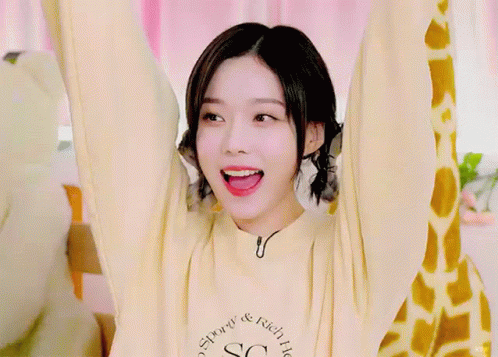

In [55]:
# 이미지 경로 설정하기
IMAGE_PATH = os.getenv('HOME') +'/aiffel/face_detector/images'

In [77]:
test_image_path_list = [
    os.path.join(IMAGE_PATH, 'aespa1.jpg'),
    os.path.join(IMAGE_PATH, 'aespa2.jpg'),
    os.path.join(IMAGE_PATH, 'aespa3.jpeg'),
    os.path.join(IMAGE_PATH, 'aespa4.jpg'),
    os.path.join(IMAGE_PATH, 'aespa5.jpg'),
    os.path.join(IMAGE_PATH, 'aespa6.jpg'),
    os.path.join(IMAGE_PATH, 'aespa7.jpeg'),
    os.path.join(IMAGE_PATH, 'aespa8.jpg'),
    os.path.join(IMAGE_PATH, 'aespa9.jpg'),
    os.path.join(IMAGE_PATH, 'aespa10.jpeg'),
    os.path.join(IMAGE_PATH, 'aespa11.jpeg'),
    os.path.join(IMAGE_PATH, 'aespa12.jpeg'),
    os.path.join(IMAGE_PATH, 'aespa13.jpg')
]

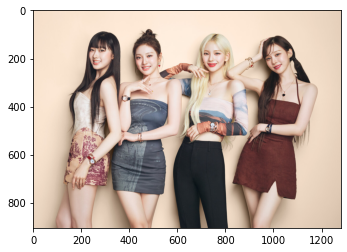

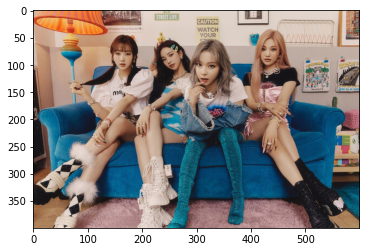

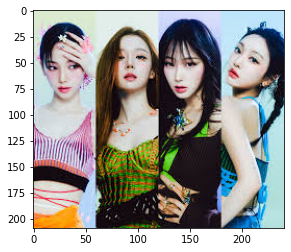

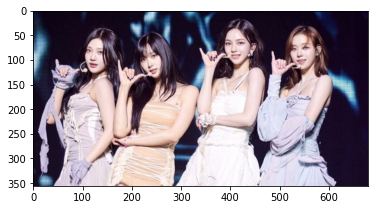

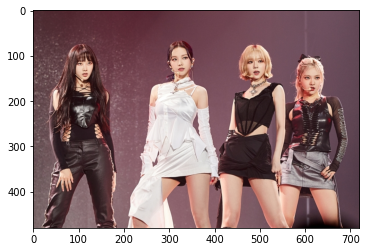

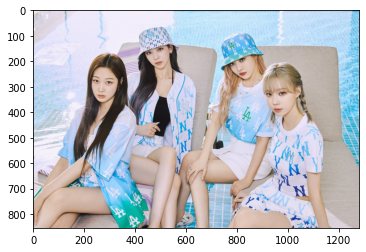

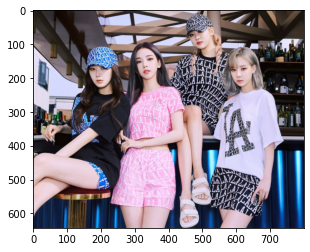

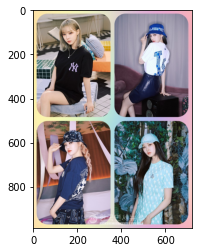

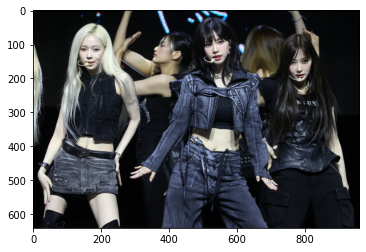

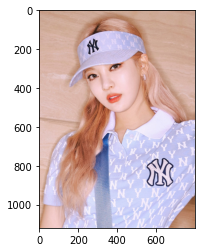

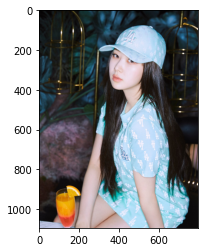

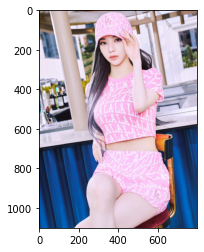

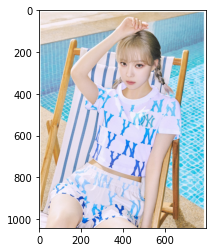

In [78]:
# 이미지 불러와서 읽기
for i, test_image_path in enumerate(test_image_path_list):
    # 이미지 읽기
    img = cv2.imread(test_image_path)  # OpenCV로 이미지를 불러오기
    
    if img is not None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print(f"이미지를 로드하지 못했습니다: {test_image_path}")

아래는 최종 결과를 시각화 할 수 있도록 이미지에 box를 그려주는 함수입니다. box 사각형과 함께 확률도 표시해 줍시다.

In [58]:
def get_face_boxes(test_image_path, image_width, image_height, box_steps):
    img_raw = cv2.imread(test_image_path)
    img_raw = cv2.resize(img_raw, (image_width, image_height))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(box_steps))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    return img_raw, pred_boxes, labels, scores

최종 결과를 시각화 할 수 있도록 이미지에 box를 그려주는 함수를 구현합니다.

box 사각형과 함께 확률도 표시합니다.

In [65]:
# 이미지에 box를 그려주는 함수 구현하기
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

In [66]:
def draw_face_boxes(img_raw, pred_boxes, labels, scores, image_labels, save_num=1):
    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, image_labels)

    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.savefig(os.path.join('result', f'face_boxes_{save_num}'))
    plt.show()

작성한 함수를 바탕으로 사진에 bounding box를 그려봅니다.

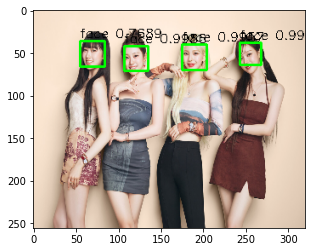

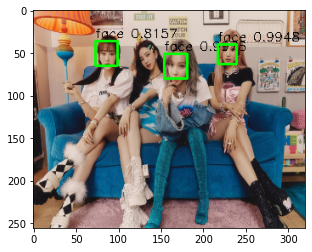

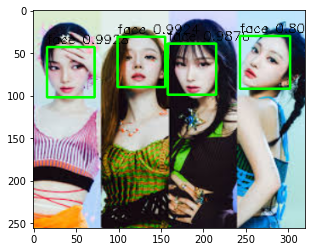

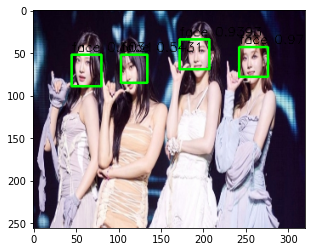

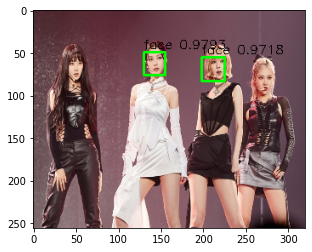

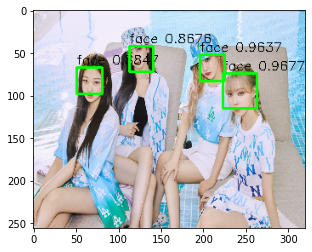

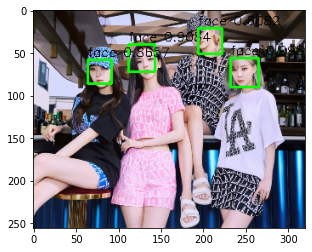

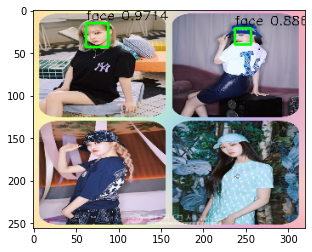

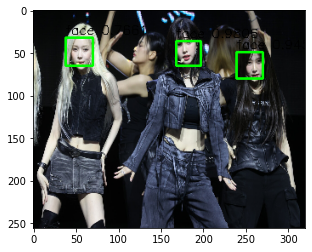

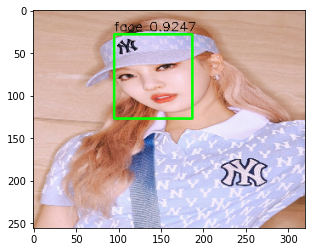

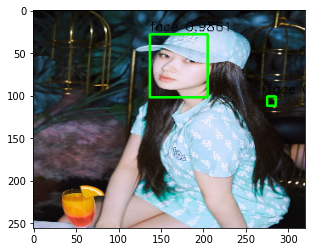

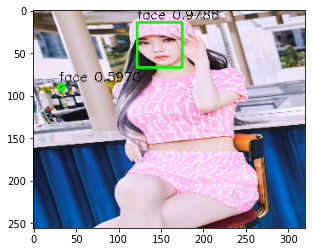

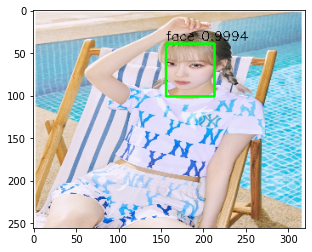

In [67]:
# 사진에 bounding box 그리기
for i, test_image_path in enumerate(test_image_path_list):
    img_raw, pred_boxes, labels, scores = get_face_boxes(test_image_path, 
                                                         IMAGE_WIDTH, 
                                                         IMAGE_HEIGHT, 
                                                         BOX_STEPS)
    draw_face_boxes(img_raw, pred_boxes, labels, scores, IMAGE_LABELS, save_num=i+1)

> 결과를 살펴보면 다음과 같습니다.
> 
> * 정면 얼굴은 잘 인식이 된 경우가 많았습니다. 특히 가까이 있는 얼굴의 경우에는 모자를 쓰고 있거나, 얼굴의 일부분을 손으로 가리고 있는 등의 경우에도 꽤나 잘 얼굴이 인식되는 것을 볼 수 있습니다.
> * 하지만 얼굴이 아닌 것을 얼굴로 인식을 하거나, 혹은 정면을 보고 있는데도, 잘 인식이 되지 않는 경우도 있었고, 특히 얼굴의 각도가 조금 틀어지면, 얼굴을 잘 인식하지 못하는 경향도 볼 수 있었습니다. 이 실험을 보고 어디까지 모델이 얼굴을 인식하는지, 혹은 어디까지 얼굴이라고 알려줘야 하는지에 대한 고민을 하게 된 것 같습니다.
> * 참고로 gif는 인식을 하지 못했습니다. 단순히 사진 파일인 경우에만 가능할 듯합니다.

에스파에 왕관을 씌우기 위해

왕관 이미지를 가져옵니다.

In [68]:
# 스티커 경로 설정하기
STICKER_PATH =  os.path.join(IMAGE_PATH, 'crown.png')

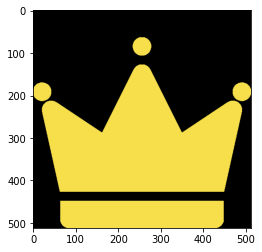

In [69]:
# 이미지를 불러오고 표시하기
img_sticker = cv2.imread(STICKER_PATH)    # OpenCV로 이미지를 불러옵니다
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

에스파의 머리에 왕관을 씌워보겠습니다.

In [70]:
# 스티커 붙이는 함수 구현하기
def put_stickers(img, boxes, prior_index, img_sticker):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[prior_index][0] * img_width)
    y_min = int(boxes[prior_index][1] * img_height)
    x_max = int(boxes[prior_index][2] * img_width)
    y_max = int(boxes[prior_index][3] * img_height)
    
    w = x_max - x_min
    h = y_max - y_min

    # print(x_min, x_max, x_max-x_min)
    # print(y_min, y_max, y_max-y_min)
    # print(img_height)
    # print(img_width)

    refined_x = x_min
    refined_y = y_min - h//4*3

    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    img_sticker = cv2.resize(img_sticker, (w, h))

    alpha = 0.2  # 투명도
    sticker_area = img_raw[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_raw[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, alpha, np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8), 1-alpha, 0)

In [71]:
def draw_stickers(img_raw, pred_boxes, img_sticker, save_num=1):
    for box_index in range(len(pred_boxes)):
        put_stickers(img_raw, pred_boxes, box_index, img_sticker)

    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.savefig(os.path.join('result', f'draw_stickers_{save_num}'))
    plt.show()

결과물을 확인해봅니다.

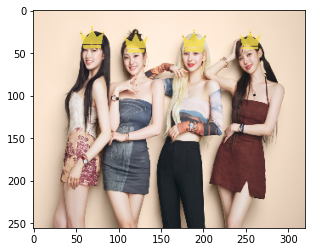

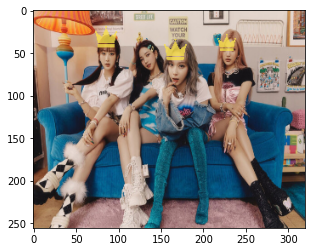

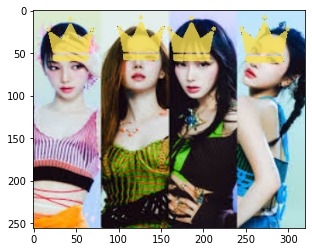

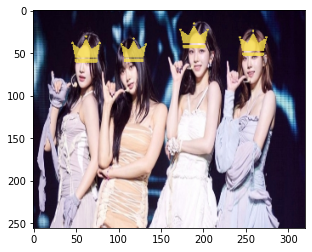

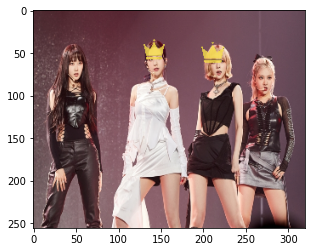

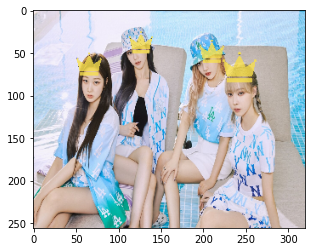

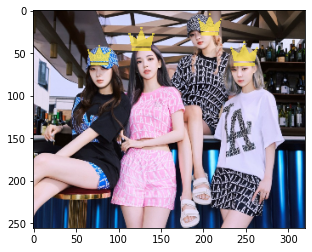

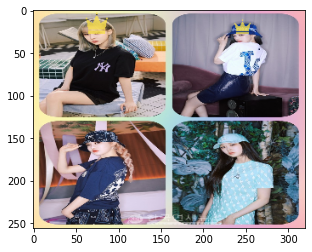

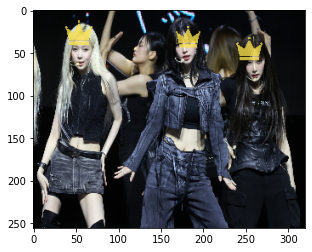

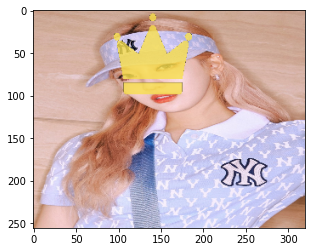

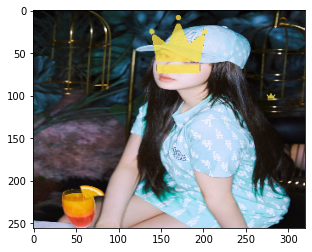

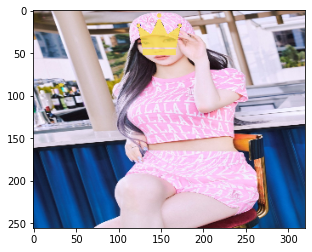

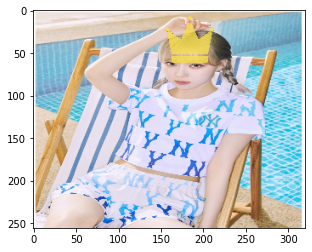

In [80]:
for i, test_image_path in enumerate(test_image_path_list):
    img_raw, pred_boxes, labels, scores = get_face_boxes(test_image_path, 
                                                         IMAGE_WIDTH, 
                                                         IMAGE_HEIGHT, 
                                                         BOX_STEPS)
    draw_stickers(img_raw, pred_boxes, img_sticker, save_num=i+1)

dlib으로 만든 고양이 수염 결과와 비교해봅니다.

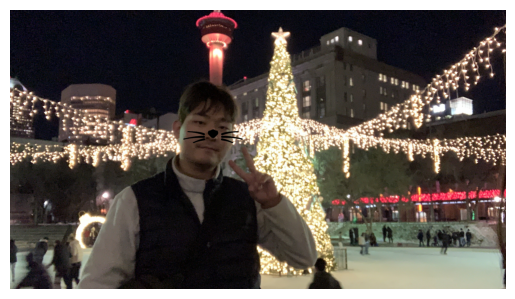

> * SSD를 활용한 방법의 경우, 얼굴의 위치를 인식하여 왕관을 씌웠기 때문에, 얼굴이 잘 인식된 경우 대부분 제 위치에 왕관이 잘 씌워 있었다. 다만 얼굴이 잘 인식되지 않거나, 측면 얼굴이거나 일부분의 사진의 경우에는 왕관이 제 자리에 들어가지 못한 경우도 있었다.
> * OpenCV에서 제시된 dlib을 활용한 사진의 경우 얼굴의 크기와 위치에 관계없이 동일하게 스티커가 붙는 경우가 있었다. 특히 OpenCV에서는 직접 좌표를 설정했어야 했는데, SSD는 그러지 않아서 편한 점도 있었다.

## **2. 회고하기**

**[배운 점 & 느낀 점]** SSD를 활용하여 bounding box를 그리고, 또한 얼굴에 스티커까지 붙이는 연습을 해봤는데, 생각보다 정확도가 높아서 신기했다. 특히 정면 사진은 굉장히 bounding box가 잘 그려졌다. 특히 얼굴의 일부가 모자로 인해 가려져 있거나. 손으로 막았을 때도 정상적으로 작동하는 것 같아서 놀랐다. Object Detection 모델은 어렵지만, 결과물이 바로 나오고 사진은 직관적으로 이해가 되어 재밌는 분야인 것 같다. 이와 관련된 공부를 더 해야 할 것 같다.

**[어려웠던 점 & 아쉬웠던 점]** 일부 사진 특히 측면의 경우에는 얼굴이 잘 인식되지 않고, 일부 사진 또한 얼굴이 잘 인식되지 않은 문제가 있었다. 또한 bounding box는 제대로 그려졌지만, 왕관은 제대로 그려지지 않은 경우가 있었다. 이 정확도를 어떻게 잡을지 몰라서 어렵고, 그렇기에 이러한 사진들은 좀 아쉬웠던 결과였지 않았나 싶다. 하지만 CV 초기 모델이기에 이를 잡을 수 있는 방법을 선행 연구자들이 연구를 이미지 했을 것 같다. 이 부분을 집중해서 공부를 하면 좋을 것 같다.